In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import ee
import geemap
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
chongqing = ee.FeatureCollection('users/311605001111/YangtzeCity/chongqing')
Map.addLayer(chongqing, {}, "chongqing")
Map.centerObject(chongqing,7)

In [4]:
# 去云掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                 .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask)
# landsat8 图像可视化参数
visParams = {
    'bands': ['B5', 'B4', 'B3'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

In [5]:
def NDVI(image):
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')  
    return image.addBands(ndvi)

def mNDWI(image):
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    return image.addBands(mndwi)

def area_after_clip(image):
    image_clip = image.clip(chongqing).select('B2').gt(0)
    image_area = image_clip.multiply(ee.Image.pixelArea()).divide(1e6)
    areas = image_area.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': chongqing.geometry(),
        'scale': 30,
        'maxPixels': 1e14
    })
    return image.clip(chongqing).set({'area': areas.get('B2')})


# RandomForest预测使用的波段
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
# 分类标签
label = 'waterclass'

In [6]:
# 添加一个底图白板
basemap = ee.Image.constant(0).clip(chongqing).select('constant').rename('waterclass')
# Map.addLayer(basemap,{'palette':['white']},"basemap")
basemap1 = ee.Image.constant(0).clip(chongqing).select('constant').rename('water_class')

# 训练&分类

In [7]:
landsat8_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(chongqing) \
    .filterDate('2018-01-01', '2018-12-31') \
    .map(maskL8sr)
# print(landsat8_images.size().getInfo())
# landsat8_images_filter = landsat8_images.map(area_after_clip).filter(ee.Filter.gt('area',0))
# print(landsat8_images_filter.size().getInfo())

landsat8_map = landsat8_images.map(NDVI).map(mNDWI)
Map.addLayer(landsat8_map.mean().clip(chongqing),visParams,'landsat image')
# 计算有效像元的个数
validPixel = landsat8_images.count().select('B2').clip(chongqing).rename('count')
# Map.addLayer(count_image,{},'count_image')

## 基于指数法采集的样本点

In [8]:
def imageSample(image):
    chongqing_mNDWI_NDVI = image.select('mNDWI').gt(image.select('NDVI'))
    chongqing_waterextent = chongqing_mNDWI_NDVI.clip(chongqing).select('mNDWI').rename('waterclass')
    points = chongqing_waterextent.sample(**{
        'region': chongqing,
        'scale': 30,
        'numPixels': 200,
        'seed': 0,
        'geometries': True  # Set this to False to ignore geometries
    })
    # Overlay the points on the imagery to get training.
    sample_point = image.select(bands).sampleRegions(**{
        'collection': points,
        'properties': [label],
        'scale': 30
    })
    return sample_point

In [9]:
points_collection = landsat8_map.map(imageSample)
# print('total sample number:{}'.format(points_collection.size().getInfo()))
print(points_collection.first().getInfo())

{'type': 'FeatureCollection', 'columns': {}, 'properties': {'system:index': 'LC08_125038_20180116', 'band_order': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']}, 'features': []}


In [10]:
# samplepoint_water = points_collection.filter(ee.Filter.eq('waterclass',1))
# print(samplepoint_water.first().getInfo())

## 基于JRC采集的样本点

In [11]:
JRC_wuhan_water = ee.Image("JRC/GSW1_2/YearlyHistory/2018").clip(chongqing)
JRC_permanentwater = JRC_wuhan_water.eq(3).select("waterClass").rename('waterclass')
JRC_samplepoints = JRC_permanentwater.sample(**{
    'region': chongqing,
    'scale': 30,
    'numPixels': 3000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

def imageSample_JRC(image):
    sample_point = image.select(bands).sampleRegions(**{
        'collection': JRC_samplepoints,
        'properties': ['waterclass'],
        'scale': 30
    })
    return sample_point
points_collection_JRC =landsat8_map.map(imageSample_JRC)
print(points_collection_JRC.first().getInfo())
# print('total sample number:{}'.format(points_collection_JRC.size().getInfo()))
# samplepoint_water = points_collection_JRC.filter(ee.Filter.eq('waterclass',1))
# print('water sample number:{}'.format(samplepoint_water.size().getInfo()))

{'type': 'FeatureCollection', 'columns': {}, 'properties': {'system:index': 'LC08_125038_20180116', 'band_order': ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']}, 'features': []}


## 训练

In [12]:
## 训练

all_points_collection = points_collection.merge(points_collection_JRC).flatten()
trainedClassifier = ee.Classifier.smileRandomForest(20).train(all_points_collection,label,bands)
#对Landsat-8进行分类
def training(image):
    return image.clip(chongqing).select(bands).classify(trainedClassifier).eq(1).selfMask().select('classification').rename('waterclass')
landsatImage_classify = landsat8_map.map(training)
waterpixel_count = landsatImage_classify.sum()

# print(landsatImage_classify.size().getInfo())
# Map.addLayer(waterpixel_count,{},"waterPixelCount")
chongqing_waterfrequency = waterpixel_count.select('waterclass').divide(validPixel.select('count')).select('waterclass').rename('frequency')
chongqing_permanentwater = chongqing_waterfrequency.gte(0.75).selfMask().select('frequency').rename('waterclass')

Map.addLayer(chongqing_permanentwater,{'palette':['blue']},"permanentwater")

In [14]:
## 训练
points_collection = landsat8_map.map(imageSample).flatten()
trainedClassifier = ee.Classifier.smileRandomForest(20).train(points_collection,label,bands)
#对Landsat-8进行分类
def training(image):
    return image.clip(chongqing).select(bands).classify(trainedClassifier).eq(1).selfMask().select('classification').rename('waterclass')
landsatImage_classify = landsat8_map.map(training)
waterpixel_count = landsatImage_classify.sum()

# print(landsatImage_classify.size().getInfo())
# Map.addLayer(waterpixel_count,{},"waterPixelCount")
chongqing_waterfrequency = waterpixel_count.select('waterclass').divide(validPixel.select('count')).select('waterclass').rename('frequency')
chongqing_permanentwater_index = chongqing_waterfrequency.gte(0.75).selfMask().select('frequency').rename('waterclass')

Map.addLayer(chongqing_permanentwater_index,{'palette':['green']},"chongqing_waterindex")

In [15]:
## 训练
points_collection_JRC =landsat8_map.map(imageSample_JRC).flatten()
trainedClassifier = ee.Classifier.smileRandomForest(20).train(points_collection_JRC,label,bands)
#对Landsat-8进行分类
def training(image):
    return image.clip(chongqing).select(bands).classify(trainedClassifier).eq(1).selfMask().select('classification').rename('waterclass')
landsatImage_classify = landsat8_map.map(training)
waterpixel_count = landsatImage_classify.sum()

# print(landsatImage_classify.size().getInfo())
# Map.addLayer(waterpixel_count,{},"waterPixelCount")
chongqing_waterfrequency = waterpixel_count.select('waterclass').divide(validPixel.select('count')).select('waterclass').rename('frequency')
chongqing_permanentwater_JRC = chongqing_waterfrequency.gte(0.75).selfMask().select('frequency').rename('waterclass')

Map.addLayer(chongqing_permanentwater_JRC,{'palette':['violet']},"chongqing_JRC")

Text(0.5, 1.0, 'surface water 2018(MNDWI>NDVI+JRC)')

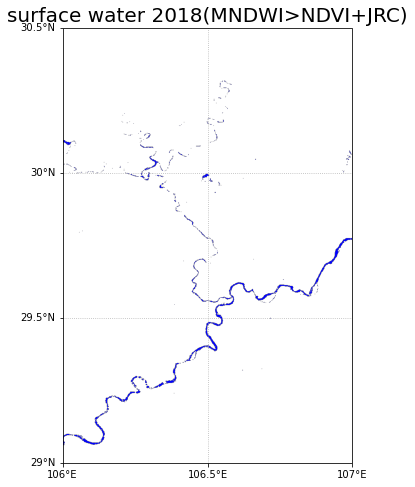

In [19]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region = [105.5, 28.5, 110.2, 31.5] 
region = [106, 29, 107, 30.5] 
vis = {'bands': ['waterclass'], 'palette': ['blue'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0}
fig = plt.figure(figsize=(12, 8))
# use cartoee to get a map
ax = cartoee.get_map(chongqing_permanentwater, region=region, vis_params=vis)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.5,0.5], linestyle=":")
ax.set_title(label = 'surface water 2018(MNDWI>NDVI+JRC)', fontsize=20)

Text(0.5, 1.0, 'surface water in 2018(MNDWI>NDVI)')

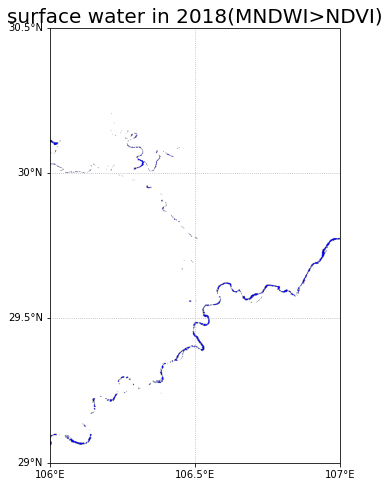

In [18]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
# region = [105.5, 28.5, 110.2, 31.5] 
region = [106, 29, 107, 30.5] 
vis = {'bands': ['waterclass'], 'palette': ['blue'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0}
fig = plt.figure(figsize=(12, 8))
# use cartoee to get a map
ax = cartoee.get_map(chongqing_permanentwater_index, region=region, vis_params=vis)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.5,0.5], linestyle=":")
ax.set_title(label = 'surface water in 2018(MNDWI>NDVI)', fontsize=20)

Text(0.5, 1.0, 'permanent surface water in 2018(JRC)')

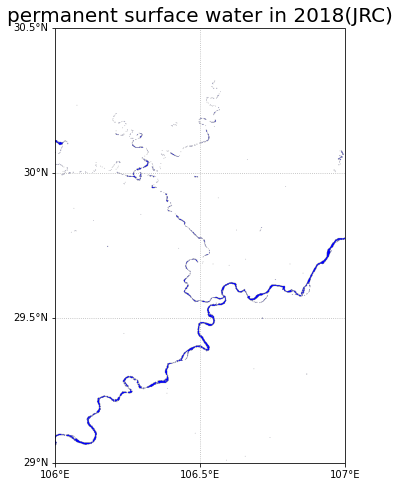

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region = [105.5, 28.5, 110.2, 31.5] 
region = [106, 29, 107, 30.5] 
vis = {'bands': ['waterclass'], 'palette': ['blue'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0}
fig = plt.figure(figsize=(12, 8))
# use cartoee to get a map
ax = cartoee.get_map(chongqing_permanentwater_JRC, region=region, vis_params=vis)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.5,0.5], linestyle=":")
ax.set_title(label = 'permanent surface water in 2018(JRC)', fontsize=20)

Text(0.5, 1.0, 'landsat image')

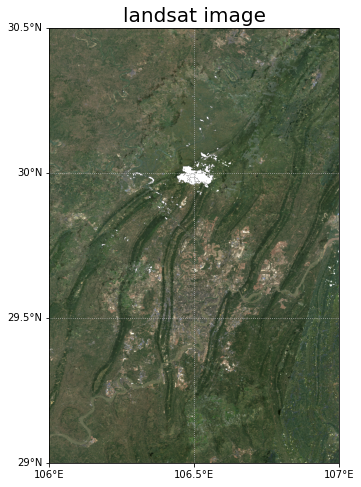

In [24]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

# region = [105.5, 28.5, 110.2, 31.5] 
region = [106, 29, 107, 30.5] 
vis = {'bands': ['waterclass'], 'palette': ['blue'], 'min': 0.0, 'max': 1.0, 'opacity': 1.0}
fig = plt.figure(figsize=(12, 8))
# use cartoee to get a map
ax = cartoee.get_map(landsat8_images.mosaic(), region=region, vis_params=visParams)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.5,0.5], linestyle=":")
ax.set_title(label = 'landsat image', fontsize=20)